<a href="https://colab.research.google.com/github/Kambey-san/NNWs_Basic/blob/HW_lesson_05/HW_lesson_05_Task_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Урок 5. Рекуррентные нейронные сети/ домашнее задание
3. Попробуйте реализовать нейронную сеть архитектуры LSTM на numpy

In [1]:
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
%matplotlib inline

## Генерируем датасет

Сгенерируем простой набор данных -- последовательности вида: `a a a a b b b b EOS`, `a a b b EOS`, `a a a a a b b b b b EOS`, где `EOS` — специальный символ, обозначающий конец последовательности. Задача состоит в том, чтобы предсказать следующий токен $𝑡_𝑛$, то есть `a`,`b`, `EOS` или неизвестный токен `UNK`, учитывая последовательность токенов $\{ t_{1}, t_{2}, \dots , t_{n-1}\}$, и мы должны обрабатывать последовательности последовательно. Таким образом, сети необходимо будет узнать, что, например. 5 `b`s и токен EOS появится после 5 `a`s.

In [2]:
# начальное значение для получения одинакового набора данных
np.random.seed(42)

In [3]:
def generate_dataset(num_sequences=100):
    """
    Генерирует несколько последовательностей в качестве нашего набора данных.

    Args:
     `num_sequences`: количество генерируемых последовательностей

    Возвращает список последовательностей.
    """
    samples = []

    for _ in range(num_sequences):
        num_tokens = np.random.randint(1, 10)
        sample = ['a'] * num_tokens + ['b'] * num_tokens + ['EOS']
        samples.append(sample)

    return samples


sequences = generate_dataset()

print('Один образец из сгенерированного набора данных:')
print(sequences[0])

Один образец из сгенерированного набора данных:
['a', 'a', 'a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'EOS']


## Представление токенов в виде индексов

Для **one-hot encoding** присваиваем каждому возможному слову в нашем словаре индекс. Т.о. создаём два словаря: один позволяет переходить от данного слова к соответствующему ему индексу в нашем словаре, а другой — в обратном направлении (word_to_idx и idx_to_word). Ключевое слово num_words определяет максимальный размер нашего словаря. Если будет запрос на доступ к слову, которого нет в нашем словаре, оно автоматически заменяется токеном UNK или соответствующим ему индексом.

In [4]:
def sequences_to_dicts(sequences):
    """
    Создает словари word_to_idx и idx_to_word для списка последовательностей.
    """
    # Немного магии Python для выравнивания вложенного списка
    flatten = lambda l: [item for sublist in l for item in sublist]

    # Сглаживаем набор данных
    all_words = flatten(sequences)

    # Подсчет количества вхождений слов
    word_count = defaultdict(int)
    for word in flatten(sequences):
        word_count[word] += 1

    # Сортировка по частоте
    word_count = sorted(list(word_count.items()), key=lambda l: -l[1])

    # Создание списока уникальных слов
    unique_words = [item[0] for item in word_count]

    # Добавить токен UNK в список слов
    unique_words.append('UNK')

    # Подсчет количества последовательностей и количества уникальных слов
    num_sentences, vocab_size = len(sequences), len(unique_words)

    # Создаем словари, чтобы переходить от слова к индексу и обратно
    # Если слова нет словаре, присваиваем его токену «UNK».
    word_to_idx = defaultdict(lambda: num_words)
    idx_to_word = defaultdict(lambda: 'UNK')

    # Заполняем словари
    for idx, word in enumerate(unique_words):
        word_to_idx[word] = idx
        idx_to_word[idx] = word

    return word_to_idx, idx_to_word, num_sentences, vocab_size


word_to_idx, idx_to_word, num_sequences, vocab_size = sequences_to_dicts(sequences)

print(f'Имеем {num_sequences} предложений и {len(word_to_idx)} уникальных токенов в датасете (включая UNK).\n')
print('Индекс \'b\' равен', word_to_idx['b'])
print(f'Слово, соответствующее индексу 1, --> \'{idx_to_word[1]}\'')

Имеем 100 предложений и 4 уникальных токенов в датасете (включая UNK).

Индекс 'b' равен 1
Слово, соответствующее индексу 1, --> 'b'


## Разделение набора данных

Cоздаём входные данные и целевые значения (цели) для каждой последовательности и разделяем их на обучающие, проверочные и тестовые наборы. 80%, 10% и 10%

Использую класс Dataset PyTorch для создания простого набора данных, из которого можно получить пары (входные данные - целевые значения) для каждой из последовательностей.

In [5]:
from torch.utils import data

class Dataset(data.Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets

    def __len__(self):
        # Возвращает размер датасета
        return len(self.targets)

    def __getitem__(self, index):
        # Входные данные и цели по заданному индексу
        X = self.inputs[index]
        y = self.targets[index]

        return X, y


def create_datasets(sequences, dataset_class, p_train=0.8, p_val=0.1, p_test=0.1):
    # размеры разделов
    num_train = int(len(sequences)*p_train)
    num_val = int(len(sequences)*p_val)
    num_test = int(len(sequences)*p_test)

   # Разделяет последовательности на разделы
    sequences_train = sequences[:num_train]
    sequences_val = sequences[num_train:num_train+num_val]
    sequences_test = sequences[-num_test:]

    def get_inputs_targets_from_sequences(sequences):
        # Определияет пустые списки
        inputs, targets = [], []

       # Добавляем входные данные и целевые значения s.t., оба списка содержат L-1 слов предложения длиной L
       # (!) целевые значения сдвигаются вправо на единицу, чтобы предсказать следующее слово
        for sequence in sequences:
            inputs.append(sequence[:-1])
            targets.append(sequence[1:])

        return inputs, targets

    # Получаем входные данные и цели для каждого раздела
    inputs_train, targets_train = get_inputs_targets_from_sequences(sequences_train)
    inputs_val, targets_val = get_inputs_targets_from_sequences(sequences_val)
    inputs_test, targets_test = get_inputs_targets_from_sequences(sequences_test)

    # Создаём датасеты
    training_set = dataset_class(inputs_train, targets_train)
    validation_set = dataset_class(inputs_val, targets_val)
    test_set = dataset_class(inputs_test, targets_test)

    return training_set, validation_set, test_set


training_set, validation_set, test_set = create_datasets(sequences, Dataset)

print(f'В обучающем наборе {len(training_set)} образцов.')
print(f'В валидационном наборе {len(validation_set)} образцов.')
print(f'В тестовом наборе {len(test_set)} образцов.')

В обучающем наборе 80 образцов.
В валидационном наборе 10 образцов.
В тестовом наборе 10 образцов.


## Прожариваем! (one-hot encodings)

Форма one-hot encodings равна словарному запасу. Определяем функцию one-hot encoding для автоматического кодирования предложения и параметры one_hot_encode (idx, vocab_size):

In [6]:
# Cоздадим простую функцию, которая возвращает представление заданного индекса слова в нашем словаре

def one_hot_encode(idx, vocab_size):
    """
    One-hot кодирует одно слово, учитывая его индекс и размер словаря.

    Args:
     `idx`: индекс данного слова
     `vocab_size`: размер словаря

     Возвращает 1-D длину numpy массива `vocab_size`.
    """
    # Инициализация закодированного массиваа
    one_hot = np.zeros(vocab_size)

    # Установка one_hot на единицу
    one_hot[idx] = 1.0

    return one_hot


def one_hot_encode_sequence(sequence, vocab_size):
    """
    One-hot кодирует последовательность слов с фиксированным размером словаря.

    Args:
     `sentence`: список слов для кодирования
     `vocab_size`: размер словаря

    Возвращает 3-D numpy массив формы (num words, vocab size, 1).
    """
    # Кодируем каждое слово в предложении
    encoding = np.array([one_hot_encode(word_to_idx[word], vocab_size) for word in sequence])

    # Reshape encoding (num words, vocab size, 1)
    encoding = encoding.reshape(encoding.shape[0], encoding.shape[1], 1)

    return encoding


test_word = one_hot_encode(word_to_idx['a'], vocab_size)
print(f'One-hot encoding \'a\' имеет форму {test_word.shape}.')

test_sentence = one_hot_encode_sequence(['a', 'b'], vocab_size)
print(f'One-hot encoding \'a b\' имеет форму {test_sentence.shape}.')

One-hot encoding 'a' имеет форму (4,).
One-hot encoding 'a b' имеет форму (2, 4, 1).


Это были только подготовительные работы... Теперь за нейронку!

### Размеры...

In [7]:
hidden_size = 50 # Количество измерений в скрытом состоянии
vocab_size  = len(word_to_idx) # Размер используемого словаря

### Функция для инициализации ортогональных параметров

In [8]:
# Функция инициализации ортогональных параметров

def init_orthogonal(param):
    """
    Инициализирует ортогональные параметры весов.

    """
    if param.ndim < 2:
        raise ValueError("Поддерживаются только параметры с двумя или более измерениями.")

    rows, cols = param.shape

    new_param = np.random.randn(rows, cols)

    if rows < cols:
        new_param = new_param.T

    # Вычисление QR-факторизации
    q, r = np.linalg.qr(new_param)

    # Делает Q однообразным в соответствии с https://arxiv.org/pdf/math-ph/0609050.pdf
    d = np.diag(r, 0)
    ph = np.sign(d)
    q *= ph

    if rows < cols:
        q = q.T

    new_param = q

    return new_param

### Определения функций активации

#### Sigmoid

In [9]:
def sigmoid(x, derivative=False):
    """
    Вычисляет поэлементную функцию активации сигмоида для массива x.

    Args:
     `x`: массив, к которому применяется функция
     `derivative`: если установлено значение True, будет возвращена производная вместо прямого прохода.
    """
    x_safe = x + 1e-12
    f = 1 / (1 + np.exp(-x_safe))

    if derivative: # Возвращает производную функции, оцененную в точке x
        return f * (1 - f)
    else: # Возвращает прямой проход функции в точке x
        return f

#### Hyperbolic Tangent (tanh)

In [10]:
def tanh(x, derivative=False):
    """
    Вычисляет поэлементную функцию активации tanh для массива x.

    Args:
     `x`: массив, к которому применяется функция
     `derivative`: если установлено значение True, будет возвращена производная вместо прямого прохода.
    """
    x_safe = x + 1e-12
    f = (np.exp(x_safe)-np.exp(-x_safe))/(np.exp(x_safe)+np.exp(-x_safe))

    if derivative: # Возвращает производную функции, оцененную в точке x
        return 1-f**2
    else: # Возвращает прямой проход функции в точке x
        return f

#### Softmax

In [11]:
def softmax(x, derivative=False):
    """
    Вычисляет softmax для массива x.

    Args:
     `x`: массив, к которому применяется функция
     `derivative`: если установлено значение True, будет возвращена производная вместо прямого прохода.
    """
    x_safe = x + 1e-12
    f = np.exp(x_safe) / np.sum(np.exp(x_safe))

    if derivative: # Возвращает производную функции, оцененную в точке x
        pass
    else:  # Возвращает прямой проход функции в точке x
        return f

### Оптимизация

In [12]:
# как Optimizer.step() в PyTorch
def update_parameters(params, grads, lr=1e-3):
    for param, grad in zip(params, grads):
        param -= lr * grad

    return params

## Инициализируем LSTM

Реализуем цикл прямого и обратного прохода, оптимизации и обучения для LSTM

In [13]:
# Размер объединенного скрытого входного вектора
z_size = hidden_size + vocab_size

In [14]:
# Функция инициализации LSTM

def init_lstm(hidden_size, vocab_size, z_size):
    """
    Инициализация конфигурации LSTM.

    Args:
     `hidden_size`: размеры скрытого состояния
     `vocab_size`: размеры словаря
     `z_size`: размеры объединенного ввода
    """
    # Матрица весов фильтра "забвения" (forget gate)
    W_f = np.random.randn(hidden_size, z_size)

    # Смещение для forget gate
    b_f = np.zeros((hidden_size, 1))

    # Матрица весов (input gate)
    W_i = np.random.randn(hidden_size, z_size)

    # Смещение для input gate
    b_i = np.zeros((hidden_size, 1))

    # Матрица весов (candidate)
    W_g = np.random.randn(hidden_size, z_size)

    # Смещение для candidate
    b_g = np.zeros((hidden_size, 1))

    # Матрица весов выходного шлюза
    W_o = np.random.randn(hidden_size, z_size)
    b_o = np.zeros((hidden_size, 1))

    # Матрица весов отношения hidden-state к output
    W_v = np.random.randn(vocab_size, hidden_size)
    b_v = np.zeros((vocab_size, 1))

    # Инициализируйте весов
    W_f = init_orthogonal(W_f)
    W_i = init_orthogonal(W_i)
    W_g = init_orthogonal(W_g)
    W_o = init_orthogonal(W_o)
    W_v = init_orthogonal(W_v)

    return W_f, W_i, W_g, W_o, W_v, b_f, b_i, b_g, b_o, b_v


params = init_lstm(hidden_size=hidden_size, vocab_size=vocab_size, z_size=z_size)

## Прямой проход

Объединяем уравнения в фрагменты кода:

In [15]:
def forward(inputs, h_prev, C_prev, p):
    """
    Args:
    x -- входные данные на временном интервале "t", форма numpy массива (n_x, m).
    h_prev -- скрытые структуры на временном интервале "t-1", форма numpy массива (n_a, m)
    C_prev -- запоминание структуры на временном интервале "t-1", форма numpy массива (n_a, m)
    p -- содержание списка python:
                        W_f -- Матрица весов фильтра "забвения" (forget gate), форма numpy массива (n_a, n_a + n_x)
                        b_f -- Смещение для forget gate, форма numpy массива (n_a, 1)
                        W_i -- Матрица весов (input gate), форма numpy массива (n_a, n_a + n_x)
                        b_i -- Смещение для input gate, форма numpy массива (n_a, 1)
                        W_g -- Матрица весов (первый tanh), форма numpy массива (n_a, n_a + n_x)
                        b_g -- Смещение первого "tanh", форма numpy массива (n_a, 1)
                        W_o -- Матрица весов выходного шлюза, форма numpy массива (n_a, n_a + n_x)
                        b_o -- Смещение выходного шлюза, форма numpy массива (n_a, 1)
                        W_v -- Матрица весов отношения hidden-state к output, форма numpy массива (n_v, n_a)
                        b_v -- Смещение отношения hidden-state к output, форма numpy массива (n_v, 1)
    Returns:
    z_s, f_s, i_s, g_s, C_s, o_s, h_s, v_s -- списки размера m, содержащие вычисления в каждом прямом проходе
    выходные данные -- прогноз на временном интервале «t», форма numpy массива (n_v, m)
    """
    assert h_prev.shape == (hidden_size, 1)
    assert C_prev.shape == (hidden_size, 1)

    # Распаковка параметров
    W_f, W_i, W_g, W_o, W_v, b_f, b_i, b_g, b_o, b_v = p

    # Сохранение списока вычислений для каждого из компонентов в LSTM.
    x_s, z_s, f_s, i_s,  = [], [] ,[], []
    g_s, C_s, o_s, h_s = [], [] ,[], []
    v_s, output_s =  [], []

    # Добавление исходной ячейки и скрытого состояния в соответствующие списки.
    h_s.append(h_prev)
    C_s.append(C_prev)

    for x in inputs:

        # Конкатинируем input and hidden state
        z = np.row_stack((h_prev, x))
        z_s.append(z)

        # Расчёт forget gate
        f = sigmoid(np.dot(W_f, z) + b_f)
        f_s.append(f)

        # Расчёт input gate
        i = sigmoid(np.dot(W_i, z) + b_i)
        i_s.append(i)

        # Расчёт candidate
        g = tanh(np.dot(W_g, z) + b_g)
        g_s.append(g)

        # Расчёт memory state
        C_prev = f * C_prev + i * g
        C_s.append(C_prev)

        # Расчёт output gate
        o = sigmoid(np.dot(W_o, z) + b_o)
        o_s.append(o)

        # Расчёт hidden state
        h_prev = o * tanh(C_prev)
        h_s.append(h_prev)

        # Вычисление логов
        v = np.dot(W_v, h_prev) + b_v
        v_s.append(v)

        # Расчёт softmax
        output = softmax(v)
        output_s.append(output)

    return z_s, f_s, i_s, g_s, C_s, o_s, h_s, v_s, output_s


# Получаем первое предложение в тестовом наборе
inputs, targets = test_set[1]

# One-hot кодирование входной и целевую последовательностей
inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
targets_one_hot = one_hot_encode_sequence(targets, vocab_size)

# Инициализация скрытого состояние как нулей
h = np.zeros((hidden_size, 1))
c = np.zeros((hidden_size, 1))

# Прямой проход
z_s, f_s, i_s, g_s, C_s, o_s, h_s, v_s, outputs = forward(inputs_one_hot, h, c, params)

output_sentence = [idx_to_word[np.argmax(output)] for output in outputs]
print('Входящая последовательность:')
print(inputs)

print('\nЦелевая последовательность:')
print(targets)

print('\nПредсказанная последовательность:')
print([idx_to_word[np.argmax(output)] for output in outputs])

Входящая последовательность:
['a', 'a', 'a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', 'b', 'b']

Целевая последовательность:
['a', 'a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'EOS']

Предсказанная последовательность:
['EOS', 'EOS', 'EOS', 'EOS', 'EOS', 'EOS', 'EOS', 'a', 'a', 'b', 'b', 'b', 'b', 'b']


Для предотвращения проблемы <a href='https://proproprogs.ru/tensorflow/keras-resnet-revolyuciya-glubokogo-obucheniya-ischezayushchie-vzryvayushchiesya-gradienty'>взрывающихся градиентов</a> "обрезаем" их

In [16]:
def clip_gradient_norm(grads, max_norm=0.25):
    """
    Обрезает градиенты, чтобы максимальная норма была равна max_norm.
    Это необходимо для предотвращения проблемы взрывающихся градиентов!
    """
    # Устанавливаем тип данных float для max_norm
    max_norm = float(max_norm)
    total_norm = 0

    # Рассчет квадрата нормы L2 для каждого градиента и прибавьте их к total norm.
    for grad in grads:
        grad_norm = np.sum(np.power(grad, 2))
        total_norm += grad_norm

    total_norm = np.sqrt(total_norm)

    # Рассчет clipping coeficient
    clip_coef = max_norm / (total_norm + 1e-6)

    # Если total norm больше предельно допустимой нормы, то обрезать градиент
    if clip_coef < 1:
        for grad in grads:
            grad *= clip_coef

    return grads

## Обратный проход

In [17]:
def backward(z, f, i, g, C, o, h, v, outputs, targets, p = params):
    """
    Args:
    z -- объединённые данные на вход как список размера m.
    f -- вычисления forget gate как список размера m.
    i -- вычисления input gate как список размера m.
    g -- предвычисления как список размера m.
    C -- состояние ячейки как список размера m+1.
    o -- вычисления output gate computations как список размера m.
    h -- вычисления скрытого состояния как список размера m+1.
    v -- вычисления логов как список размера m.
    outputs -- outputs как список размера m.
    targets -- targets как список размера m.
    p -- содержание списка python:
                        W_f -- Матрица весов для forget gate, форма numpy массива (n_a, n_a + n_x)
                        b_f -- Смещение для forget gate, форма numpy мссива (n_a, 1)
                        W_i -- Матрица весов для update gate,  форма numpy мссива (n_a, n_a + n_x)
                        b_i -- Смещение update gate, форма numpy мссива (n_a, 1)
                        W_g -- Матрица весов для first "tanh", форма numpy мссива (n_a, n_a + n_x)
                        b_g -- Смещение first "tanh", форма numpy мссива (n_a, 1)
                        W_o -- Матрица весов для output gate, форма numpy мссива (n_a, n_a + n_x)
                        b_o -- Смещение output gate, форма numpy мссива (n_a, 1)
                        W_v -- Матрица весов отношения hidden-state к output, форма numpy мссива (n_v, n_a)
                        b_v -- Смещение отношения hidden-state к output, форма numpy мссива (n_v, 1)
    Returns:
    loss -- crossentropy loss для всех элементов на выходе
    grads -- списки градиентов каждого элемента в p
    """

    # Расапсковка параматров
    W_f, W_i, W_g, W_o, W_v, b_f, b_i, b_g, b_o, b_v = p

    # Инициализация градиентов как ноль
    W_f_d = np.zeros_like(W_f)
    b_f_d = np.zeros_like(b_f)

    W_i_d = np.zeros_like(W_i)
    b_i_d = np.zeros_like(b_i)

    W_g_d = np.zeros_like(W_g)
    b_g_d = np.zeros_like(b_g)

    W_o_d = np.zeros_like(W_o)
    b_o_d = np.zeros_like(b_o)

    W_v_d = np.zeros_like(W_v)
    b_v_d = np.zeros_like(b_v)

    # Установка следующей ячейки и скрытого состояния равными нулю
    dh_next = np.zeros_like(h[0])
    dC_next = np.zeros_like(C[0])

    # Track loss
    loss = 0

    for t in reversed(range(len(outputs))):

        # Вычислим перекрестную энтропию
        loss += -np.mean(np.log(outputs[t]) * targets[t])
        # Get the previous hidden cell state
        C_prev= C[t-1]

        # Вычислим производную отношения hidden-state к output gate
        dv = np.copy(outputs[t])
        dv[np.argmax(targets[t])] -= 1

        # Обновим градиент отношения hidden-state к output gate
        W_v_d += np.dot(dv, h[t].T)
        b_v_d += dv

        # Вычислим производную hidden state и output gate
        dh = np.dot(W_v.T, dv)
        dh += dh_next
        do = dh * tanh(C[t])
        do = sigmoid(o[t], derivative=True)*do

        # Обновим градиенты относительно выходного шлюза.
        W_o_d += np.dot(do, z[t].T)
        b_o_d += do

        # Вычислим производную состояния ячейки и кандидата g
        dC = np.copy(dC_next)
        dC += dh * o[t] * tanh(tanh(C[t]), derivative=True)
        dg = dC * i[t]
        dg = tanh(g[t], derivative=True) * dg

        # Обновим градиенты относительно кандидата
        W_g_d += np.dot(dg, z[t].T)
        b_g_d += dg

        # Вычислим производную входного шлюза и обновим его градиенты
        di = dC * g[t]
        di = sigmoid(i[t], True) * di
        W_i_d += np.dot(di, z[t].T)
        b_i_d += di

        # Вычислим производную forget gate и обновим ее градиенты.
        df = dC * C_prev
        df = sigmoid(f[t]) * df
        W_f_d += np.dot(df, z[t].T)
        b_f_d += df

        # Вычислим производную входных данных и обновим градиенты предыдущего скрытого состояния и состояния ячейки.
        dz = (np.dot(W_f.T, df)
             + np.dot(W_i.T, di)
             + np.dot(W_g.T, dg)
             + np.dot(W_o.T, do))
        dh_prev = dz[:hidden_size, :]
        dC_prev = f[t] * dC

    grads= W_f_d, W_i_d, W_g_d, W_o_d, W_v_d, b_f_d, b_i_d, b_g_d, b_o_d, b_v_d

    # Обрезка градиентов
    grads = clip_gradient_norm(grads)

    return loss, grads


# Выполнение обратного прохода
loss, grads = backward(z_s, f_s, i_s, g_s, C_s, o_s, h_s, v_s, outputs, targets_one_hot, params)

print(f'Loss {round((loss), 2)}')

Loss 4.8


## Тенировочный цикл

Epoch 0, training loss: 2.890854647364262, validation loss: 3.7434929533815504
Epoch 5, training loss: 1.2663611220300077, validation loss: 1.294977526082707
Epoch 10, training loss: 1.1197449389721497, validation loss: 1.1123985312205211
Epoch 15, training loss: 0.9084878451715894, validation loss: 0.8953275015512826
Epoch 20, training loss: 0.8230790582293601, validation loss: 0.8026328198935607
Epoch 25, training loss: 0.7816513344878614, validation loss: 0.763015914549473
Epoch 30, training loss: 0.7543948763712348, validation loss: 0.7378278385266296
Epoch 35, training loss: 0.7454469142568149, validation loss: 0.7293431044102182
Epoch 40, training loss: 0.7266914727570375, validation loss: 0.7182196383638746
Epoch 45, training loss: 0.714150692287582, validation loss: 0.7067798775968828
Epoch 50, training loss: 0.7101657195898219, validation loss: 0.7020394282344488
Epoch 55, training loss: 0.7084975278400951, validation loss: 0.6992746083940946
Epoch 60, training loss: 0.7072345

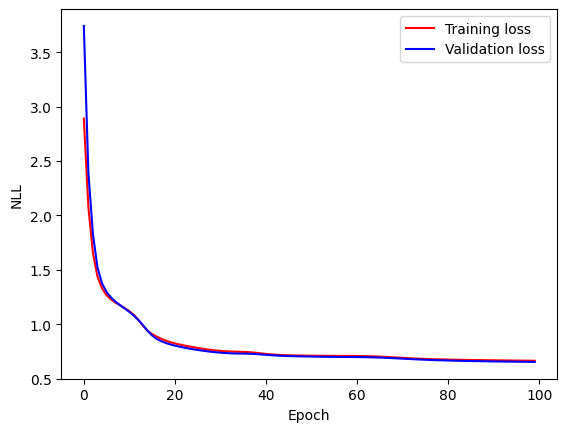

In [19]:
# Гиперпараметры:
num_epochs = 100

# Инициализация НС
z_size = hidden_size + vocab_size # Size of concatenated hidden + input vector
params = init_lstm(hidden_size=hidden_size, vocab_size=vocab_size, z_size=z_size)

# Инициализация скрытого состояния как нулей
hidden_state = np.zeros((hidden_size, 1))

# Track loss
training_loss, validation_loss = [], []

# Для каждой эпохи
for i in range(num_epochs):

    # Track loss
    epoch_training_loss = 0
    epoch_validation_loss = 0

    # Для каждого предложения в валидационном наборе
    for inputs, targets in validation_set:

        # One-hot кодировка входной и целевй последовательностей
        inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
        targets_one_hot = one_hot_encode_sequence(targets, vocab_size)

       # Инициализируем скрытое состояние и состояние ячейки как нули
        h = np.zeros((hidden_size, 1))
        c = np.zeros((hidden_size, 1))

        # Прямой проход
        z_s, f_s, i_s, g_s, C_s, o_s, h_s, v_s, outputs = forward(inputs_one_hot, h, c, params)

        # Обратный проход
        loss, _ = backward(z_s, f_s, i_s, g_s, C_s, o_s, h_s, v_s, outputs, targets_one_hot, params)

        # Обновление loss
        epoch_validation_loss += loss

    # Для каждого предложения в тренировочном наборе
    for inputs, targets in training_set:

        # One-hot кодировка входной и целевй последовательностей
        inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
        targets_one_hot = one_hot_encode_sequence(targets, vocab_size)

        # Инициализируем скрытое состояние и состояние ячейки как нули
        h = np.zeros((hidden_size, 1))
        c = np.zeros((hidden_size, 1))

        # Прямой проход
        z_s, f_s, i_s, g_s, C_s, o_s, h_s, v_s, outputs = forward(inputs_one_hot, h, c, params)

        # Обратный проход
        loss, grads = backward(z_s, f_s, i_s, g_s, C_s, o_s, h_s, v_s, outputs, targets_one_hot, params)

        # Обновление параметров
        params = update_parameters(params, grads, lr=1e-1)

        # Обновление loss
        epoch_training_loss += loss

    # Сохранение loss для plot
    training_loss.append(epoch_training_loss/len(training_set))
    validation_loss.append(epoch_validation_loss/len(validation_set))

    # Print loss каждые 5 эпох
    if i % 5 == 0:
        print(f'Epoch {i}, training loss: {training_loss[-1]}, validation loss: {validation_loss[-1]}')



# Получаем первое предложение в тестовом наборе
inputs, targets = test_set[1]

# One-hot кодировка входной и целевй последовательностей
inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
targets_one_hot = one_hot_encode_sequence(targets, vocab_size)

# Инициализируем скрытое состояние как нули
h = np.zeros((hidden_size, 1))
c = np.zeros((hidden_size, 1))

# Прямой проход
z_s, f_s, i_s, g_s, C_s, o_s, h_s, v_s, outputs = forward(inputs_one_hot, h, c, params)

# Смотрим примеры
print('Входящая последовательность:')
print(inputs)

print('\nЦелевая последовательность:')
print(targets)

print('\nПредсказанная последовательность:')
print([idx_to_word[np.argmax(output)] for output in outputs])

# График training и validation loss
epoch = np.arange(len(training_loss))
plt.figure()
plt.plot(epoch, training_loss, 'r', label='Training loss',)
plt.plot(epoch, validation_loss, 'b', label='Validation loss')
plt.legend()
plt.xlabel('Epoch'), plt.ylabel('NLL')
plt.show()